# Lab 12

## Zadanie

### Implementacja

Zaimplementuj kwantowe poszukiwanie na 4-wymiarowym hypersześcianie wg pracy (https://arxiv.org/pdf/quant-ph/0210064.pdf) w następujący sposób:

- qbity 0..3 kodują pozycję na hiperszescianie (1 qbit=1 wymiar)
- qbit 4 jest qbitem kontrolnym dla wyroczni
- qbity 5 i 6 kodują czterostronną monetę-dwuqbitowy stan monety steruje czteroqbitowym krokiem

### Algorytm

1. ustawiamy qbity monety i qbity pozycji w superpozycji (bramki H na qbitach `[0,1,2,3,5,6]` (bez 4))
2. dokonujemy$\frac{\pi}{2}\sqrt{2^{n-1}}$ kroków (n- liczba wymiarów hypercuba, uwaga na $n-1$!):
    1. rzucamy monetą
    2. robimy krok
3. powinniśmy dostać szukany stan z prawdopodobieństwem $\frac{1}{2}-O(\frac{1}{n})$

### Kroki

Dla $n = 3$, $\frac{\pi}{2}\sqrt{2^{n-1}} = {\pi}$, $\lceil{\pi}\rceil = 4$

In [1]:
from qiskit import QuantumCircuit,  QuantumRegister
from qiskit.quantum_info import Statevector
from math import pi, sqrt, ceil

In [2]:
STEPS = ceil(pi / 2 * sqrt(2 ** (3-1)))

print(f'{STEPS=}')

STEPS=4


In [3]:
def get_circuit(name):
    qr_cube = QuantumRegister(4, 'h-cube')
    qr_ctrl = QuantumRegister(1, 'ctrl')
    qr_coin = QuantumRegister(2, 'coin')
    qc = QuantumCircuit(qr_cube, qr_ctrl, qr_coin, name=name)

    return qc

def prepare(qc):
    for i in [0, 1, 2, 3, 5, 6]:
        qc.h(i)

## Bramka monety 2-qbitowej

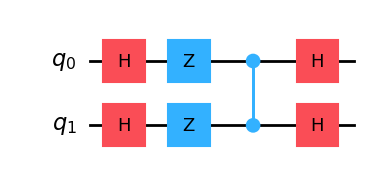

In [4]:
def diffuser():
    qc_diff = QuantumCircuit(2, name="diffuser")
    qc_diff.h([0,1])
    qc_diff.z([0,1])
    qc_diff.cz(0,1)
    qc_diff.h([0,1])

    return qc_diff

diffuser().draw('mpl')

## Bramka kroku

Chodzi po sąsiednich wierzchołkach hipersześcianu

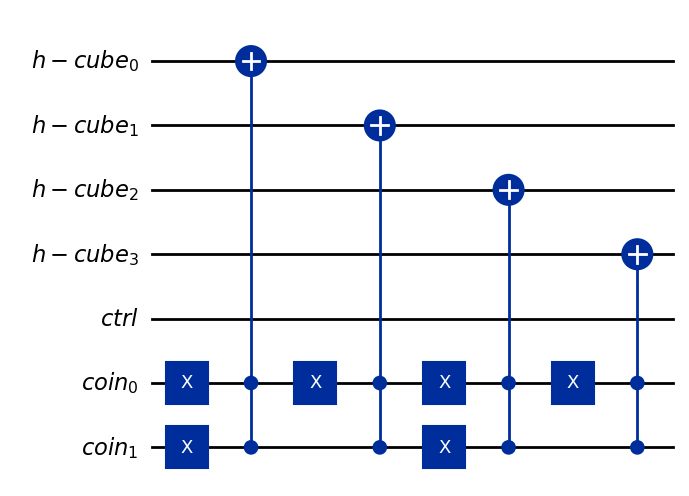

In [5]:
def shift():
    qc_shift = get_circuit('shift')

    for i in range(0, 4):
        qc_shift.x(5)
        if i % 2 == 0:
            qc_shift.x(6)
        qc_shift.ccx(5, 6, i)

    return qc_shift

shift().draw('mpl')

## Implementacja kroku

In [6]:
def coin(qc):
    qc.mcx([0, 1, 2, 3], 4)
    qc.z(4)
    qc.x(4)
    dif = diffuser().to_gate().control(1)
    qc.append(dif, [4,5,6])
    qc.x(4)

def do_steps(qc):
    for _ in range(STEPS):
        coin(qc)
        shf = shift().to_gate()
        qc.append(shf, [i for i in range(7)])

## Układ kwantowy dla 4 kroków

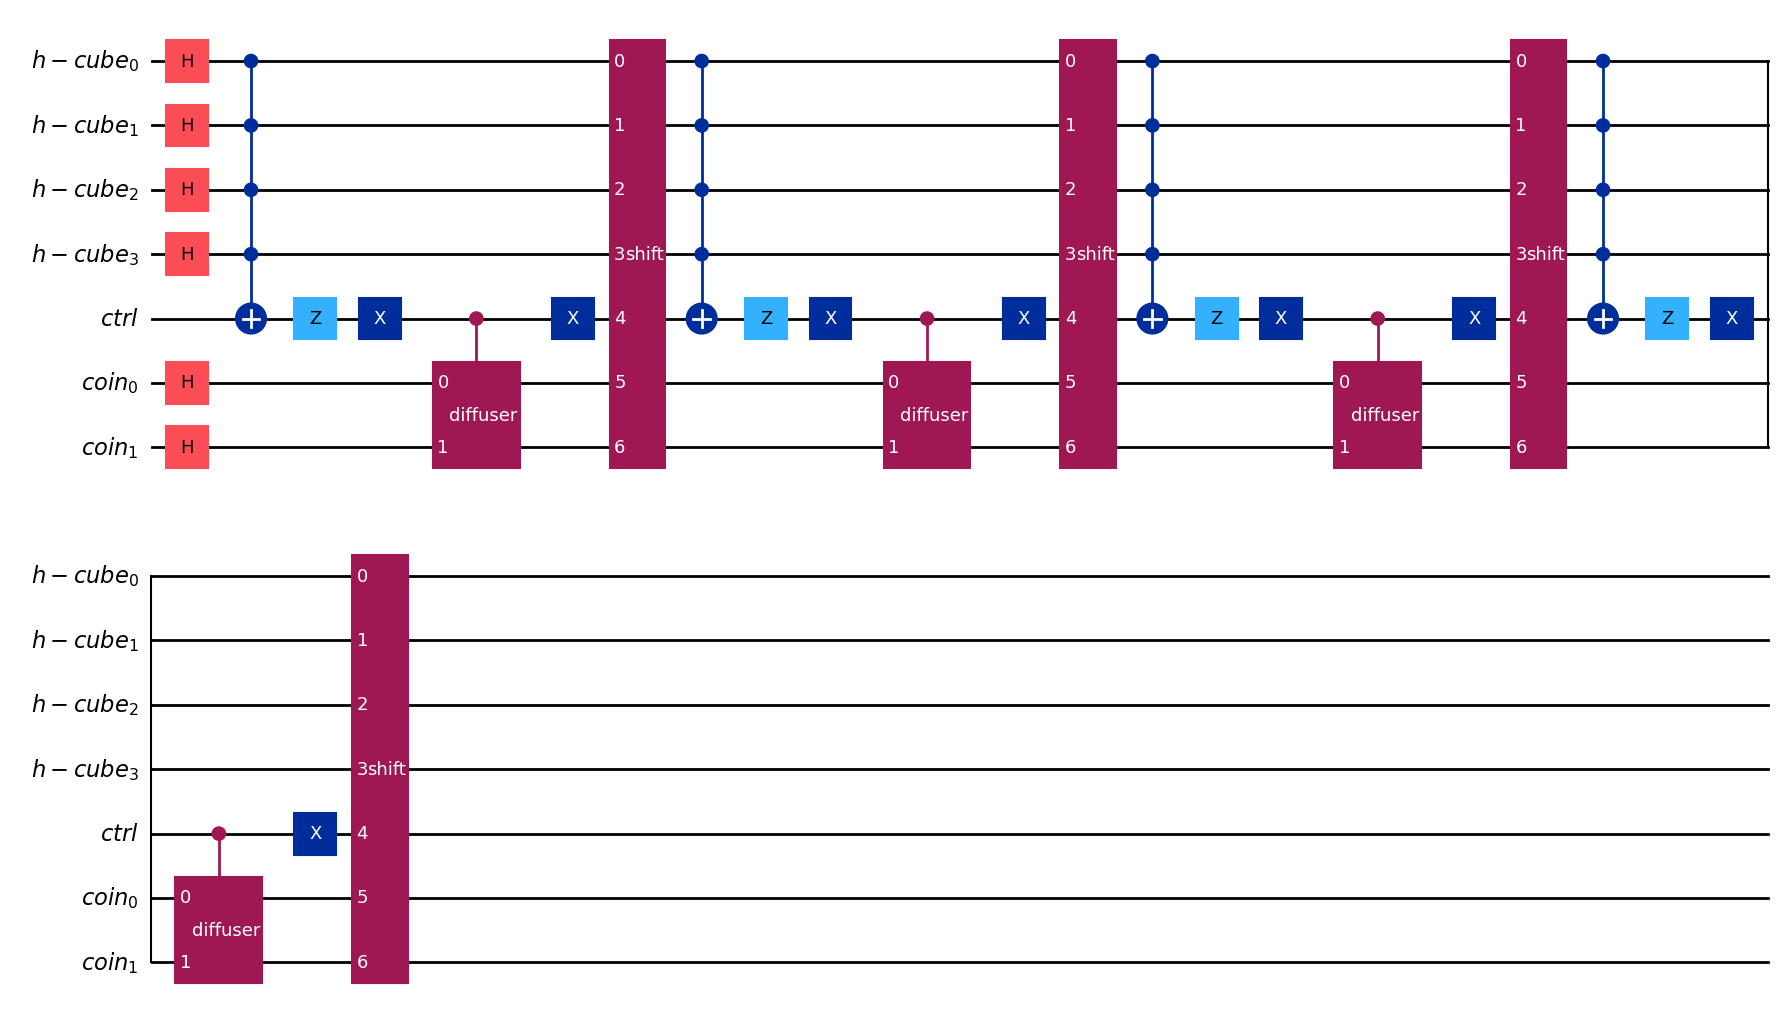

In [7]:
qc_cube = get_circuit('h-cube')
prepare(qc_cube)
do_steps(qc_cube)
qc_cube.draw('mpl')

## Stan

In [8]:
state = Statevector.from_instruction(qc_cube)
state.draw('latex')

<IPython.core.display.Latex object>

In [9]:
def get_results(st):
    results = []

    for i in range(pow(2, 7)):
        value = st[i]
        bytes_val = f'{i:07b}'
        if value.real > 0.0:
            results.append((bytes_val, value.real))

    return results

def print_results(results):
    for i, (qbit, value) in enumerate(results):
        print(f'{i:2}. |{qbit}❭ = {value:.3f}')

## Wszystkie możliwe stany

Gdzie ostatnie 4 qbity reprezentują położenie na hipersześcianie

|xxx**XXXX**❭

In [10]:
all_results = get_results(state)
all_results = sorted(all_results, key=lambda x: x[1], reverse=True)
print_results(all_results)

 0. |0111111❭ = 0.187
 1. |0011111❭ = 0.187
 2. |1011111❭ = 0.187
 3. |1111111❭ = 0.187
 4. |0101100❭ = 0.125
 5. |1001010❭ = 0.125
 6. |1101011❭ = 0.125
 7. |0001111❭ = 0.125
 8. |0101001❭ = 0.125
 9. |1000111❭ = 0.125
10. |1001001❭ = 0.125
11. |1001011❭ = 0.125
12. |1100111❭ = 0.125
13. |0001010❭ = 0.125
14. |0100010❭ = 0.125
15. |0100101❭ = 0.125
16. |0100111❭ = 0.125
17. |1001101❭ = 0.125
18. |1101000❭ = 0.125
19. |1101101❭ = 0.125
20. |0101011❭ = 0.125
21. |0101110❭ = 0.125
22. |1100101❭ = 0.125
23. |0000110❭ = 0.125
24. |1100110❭ = 0.125
25. |1101110❭ = 0.125
26. |0000111❭ = 0.125
27. |1000100❭ = 0.125
28. |1001110❭ = 0.125
29. |1001111❭ = 0.125
30. |1101111❭ = 0.125
31. |0001100❭ = 0.125
32. |0001101❭ = 0.125
33. |0001110❭ = 0.125
34. |0101101❭ = 0.125
35. |1000011❭ = 0.125
36. |0101111❭ = 0.125
37. |0000001❭ = 0.125
38. |1100011❭ = 0.125
39. |0001011❭ = 0.125
40. |1101001❭ = 0.094
41. |1101010❭ = 0.094
42. |0100110❭ = 0.094
43. |0101010❭ = 0.094
44. |0100011❭ = 0.094
45. |11011

## Stany z największym prawdopodobieństwem

Gdzie ostatnie 4 qbity reprezentują położenie na hipersześcianie

|xxx**XXXX**❭

In [11]:
top_value = all_results[0][1]
top_results = filter(lambda x: x[1] == top_value, all_results)
print_results(top_results)

 0. |0111111❭ = 0.187
